# Proyecto TRM - Analisis de Residual

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
import matplotlib.pyplot as plt

# Configuración de estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [8]:
from pathlib import Path

base = Path('.')
candidates = list(base.glob('**/Tasa*colombiano*.*'))
if not candidates:
    raise FileNotFoundError('No se encontró el archivo de tasa de cambio en el repositorio')
file_path = candidates[0]
print(f'Usando archivo: {file_path}')
if file_path.suffix.lower() in ('.xls', '.xlsx'):
    df = pd.read_excel(file_path)
else:
    df = pd.read_csv(file_path, encoding='latin1', sep=';')

Usando archivo: Tasa de cambio del peso colombiano .xlsx


In [9]:
df_clean = df.iloc[8857-730:8857]
df_clean = df_clean.reset_index(drop=True)
# df_clean = df.iloc[:8857]

In [10]:
# Seleccionamos las columnas y filas de interes para hacer los calculos con pandas
df_preprocessed = df_clean[['periodo', 'trm']]
df_preprocessed

# Se hace el calculo de primera y segunda diferencia
df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)

/tmp/ipykernel_1969/601938330.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['primera_dif'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_1969/601938330.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['segunda_dif'] =df_preprocessed['trm'] - df_preprocessed['trm'].shift(2)


In [11]:
# Se calcula el valor minimo, maximo, promedio y desviacion estandar de la primera diferencia
min_diff = df_preprocessed['primera_dif'].min()
max_diff = df_preprocessed['primera_dif'].max()
mean_diff = df_preprocessed['primera_dif'].mean()
std_diff = df_preprocessed['primera_dif'].std()
min_trm = df_preprocessed['trm'].min()
max_trm = df_preprocessed['trm'].max()
min_diff, max_diff, mean_diff, std_diff

(np.float64(-154.6899999999996),
 np.float64(144.01999999999953),
 np.float64(-1.1582716049382724),
 np.float64(32.62069875697272))

In [12]:
df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
# Normalización min-max de la columna trm
df_preprocessed['trans_max_min_trm'] = (df_preprocessed['trm'] - min_trm) / (max_trm - min_trm)
df_preprocessed['primera_dif_trans_max_min_trm'] = df_preprocessed['trans_max_min_trm'].diff()


/tmp/ipykernel_1969/241726627.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['trans_max_min_primera_dif'] = (df_preprocessed['primera_dif'] - min_diff) / (max_diff - min_diff)
/tmp/ipykernel_1969/241726627.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['estandarizacion'] = (df_preprocessed['primera_dif'] - mean_diff) / std_diff
/tmp/ipykernel_1969/241726627.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

In [13]:
# Se agregan lo rezagos
df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
df_preprocessed['y_t-2'] = df_preprocessed['y_t-1'].shift(1)
df_preprocessed['y_t-3'] = df_preprocessed['y_t-2'].shift(1)


/tmp/ipykernel_1969/98760068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t'] = df_preprocessed['trm'].diff()
/tmp/ipykernel_1969/98760068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['y_t-1'] = df_preprocessed['y_t'].shift(1)
/tmp/ipykernel_1969/98760068.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

In [14]:
# Promedios moviles (ventana de 2 filas incluyendo la actual)
df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
df_preprocessed['m_3'] = df_preprocessed['y_t'].rolling(window=4, min_periods=4).mean()

/tmp/ipykernel_1969/923652204.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_1'] = df_preprocessed['y_t'].rolling(window=2, min_periods=2).mean()
/tmp/ipykernel_1969/923652204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed['m_2'] = df_preprocessed['y_t'].rolling(window=3, min_periods=3).mean()
/tmp/ipykernel_1969/923652204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

In [15]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
0,2023-01-20,4683.85,NaN,NaN,NaN,NaN,0.765168,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-23,4631.64,-52.21,NaN,0.343075,-1.565010,0.721764,-0.043403,-52.21,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-24,4551.02,-80.62,-132.83,0.247966,-2.435930,0.654743,-0.067021,-80.62,-52.21,NaN,NaN,-66.415,NaN,NaN
3,2023-01-25,4545.94,-5.08,-85.70,0.500854,-0.120222,0.650520,-0.004223,-5.08,-80.62,-52.21,NaN,-42.850,-45.970000,NaN
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


## Análisis Exploratorio de Datos (EDA)

In [16]:
# Información general del dataset
print("=" * 60)
print("INFORMACIÓN GENERAL DEL DATASET")
print("=" * 60)
print(f"\nCantidad de registros: {len(df_preprocessed)}")
print(f"Cantidad de columnas: {len(df_preprocessed.columns)}")
print(f"\nColumnas: {list(df_preprocessed.columns)}")
print(f"\nRango de fechas: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"\nValores nulos por columna:")
print(df_preprocessed.isnull().sum())

INFORMACIÓN GENERAL DEL DATASET

Cantidad de registros: 730
Cantidad de columnas: 15

Columnas: ['periodo', 'trm', 'primera_dif', 'segunda_dif', 'trans_max_min_primera_dif', 'estandarizacion', 'trans_max_min_trm', 'primera_dif_trans_max_min_trm', 'y_t', 'y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']

Rango de fechas: 2023-01-20 00:00:00 a 2025-11-06 00:00:00

Valores nulos por columna:
periodo                          0
trm                              0
primera_dif                      1
segunda_dif                      2
trans_max_min_primera_dif        1
estandarizacion                  1
trans_max_min_trm                0
primera_dif_trans_max_min_trm    1
y_t                              1
y_t-1                            2
y_t-2                            3
y_t-3                            4
m_1                              2
m_2                              3
m_3                              4
dtype: int64


In [17]:
# Estadísticas descriptivas de las variables principales
print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - TRM")
print("=" * 60)
print(df_preprocessed['trm'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['primera_dif'].describe())

print("\n" + "=" * 60)
print("ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA")
print("=" * 60)
print(df_preprocessed['segunda_dif'].describe())


ESTADÍSTICAS DESCRIPTIVAS - TRM
count     730.000000
mean     4158.010452
std       248.679498
min      3763.430000
25%      3958.535000
50%      4111.450000
75%      4281.985000
max      4966.330000
Name: trm, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - PRIMERA DIFERENCIA
count    729.000000
mean      -1.158272
std       32.620699
min     -154.690000
25%      -20.890000
50%       -0.450000
75%       14.860000
max      144.020000
Name: primera_dif, dtype: float64

ESTADÍSTICAS DESCRIPTIVAS - SEGUNDA DIFERENCIA
count    728.000000
mean      -2.202679
std       49.832525
min     -174.160000
25%      -33.560000
50%       -5.355000
75%       23.827500
max      244.520000
Name: segunda_dif, dtype: float64


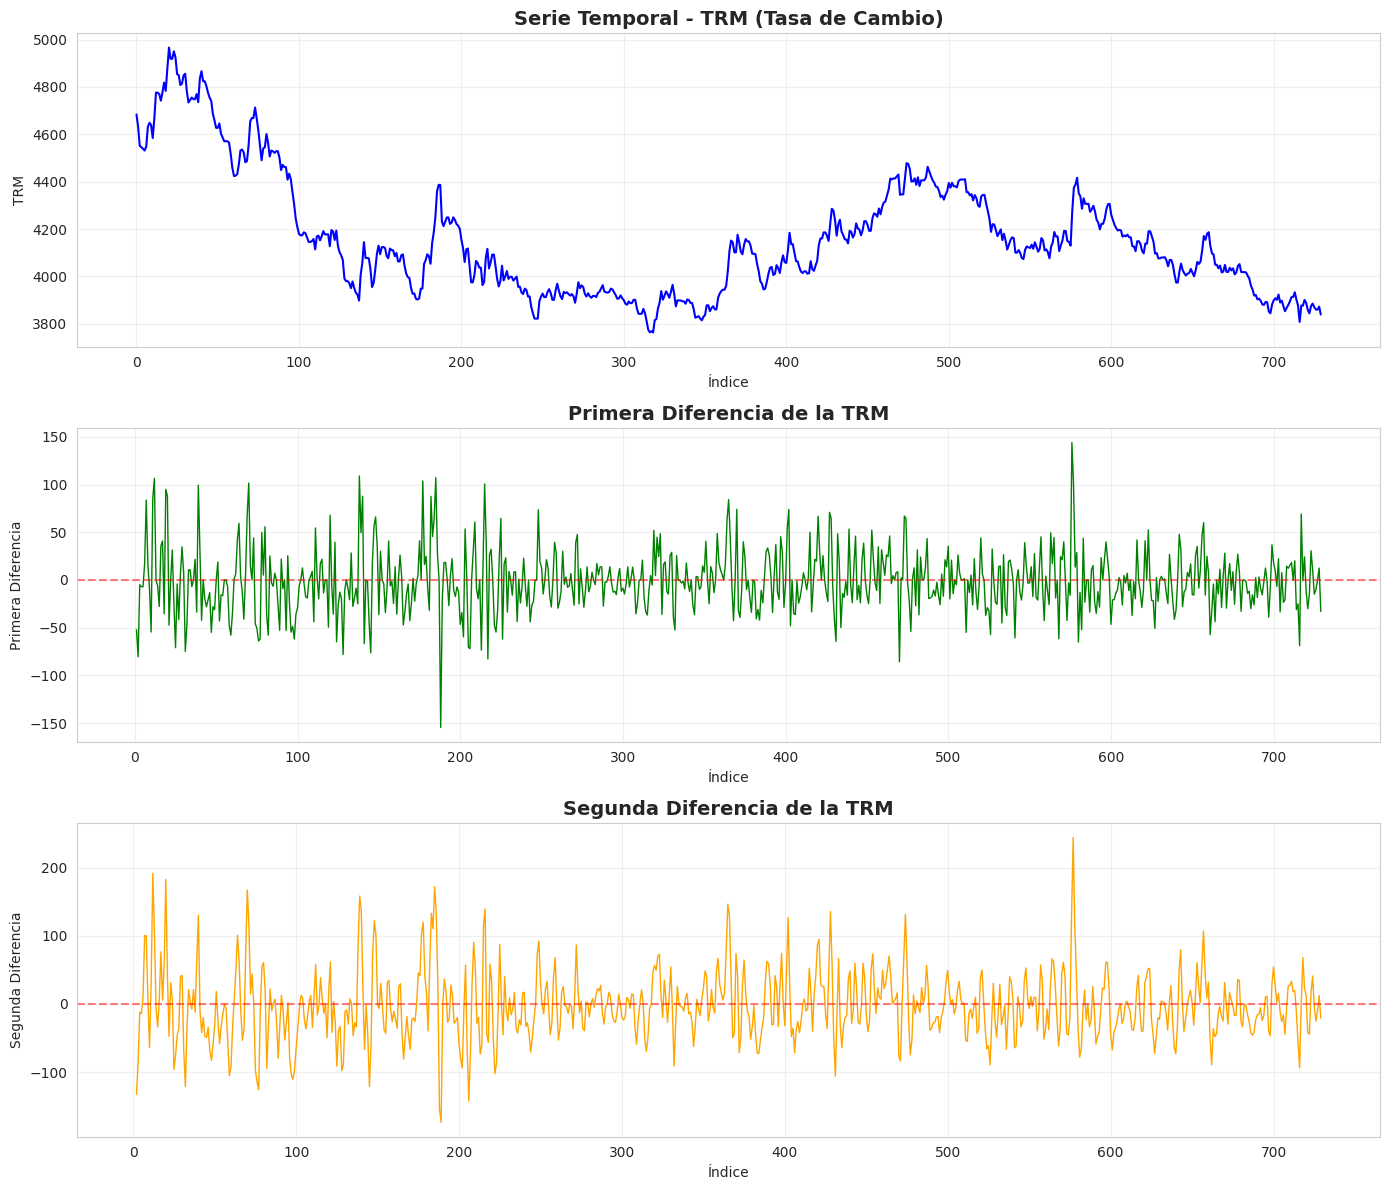

In [18]:
# Serie temporal de la TRM
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# TRM original
axes[0].plot(df_preprocessed.index, df_preprocessed['trm'], color='blue', linewidth=1.5)
axes[0].set_title('Serie Temporal - TRM (Tasa de Cambio)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Índice')
axes[0].set_ylabel('TRM')
axes[0].grid(True, alpha=0.3)

# Primera diferencia
axes[1].plot(df_preprocessed.index, df_preprocessed['primera_dif'], color='green', linewidth=1)
axes[1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1].set_title('Primera Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Índice')
axes[1].set_ylabel('Primera Diferencia')
axes[1].grid(True, alpha=0.3)

# Segunda diferencia
axes[2].plot(df_preprocessed.index, df_preprocessed['segunda_dif'], color='orange', linewidth=1)
axes[2].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[2].set_title('Segunda Diferencia de la TRM', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Índice')
axes[2].set_ylabel('Segunda Diferencia')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

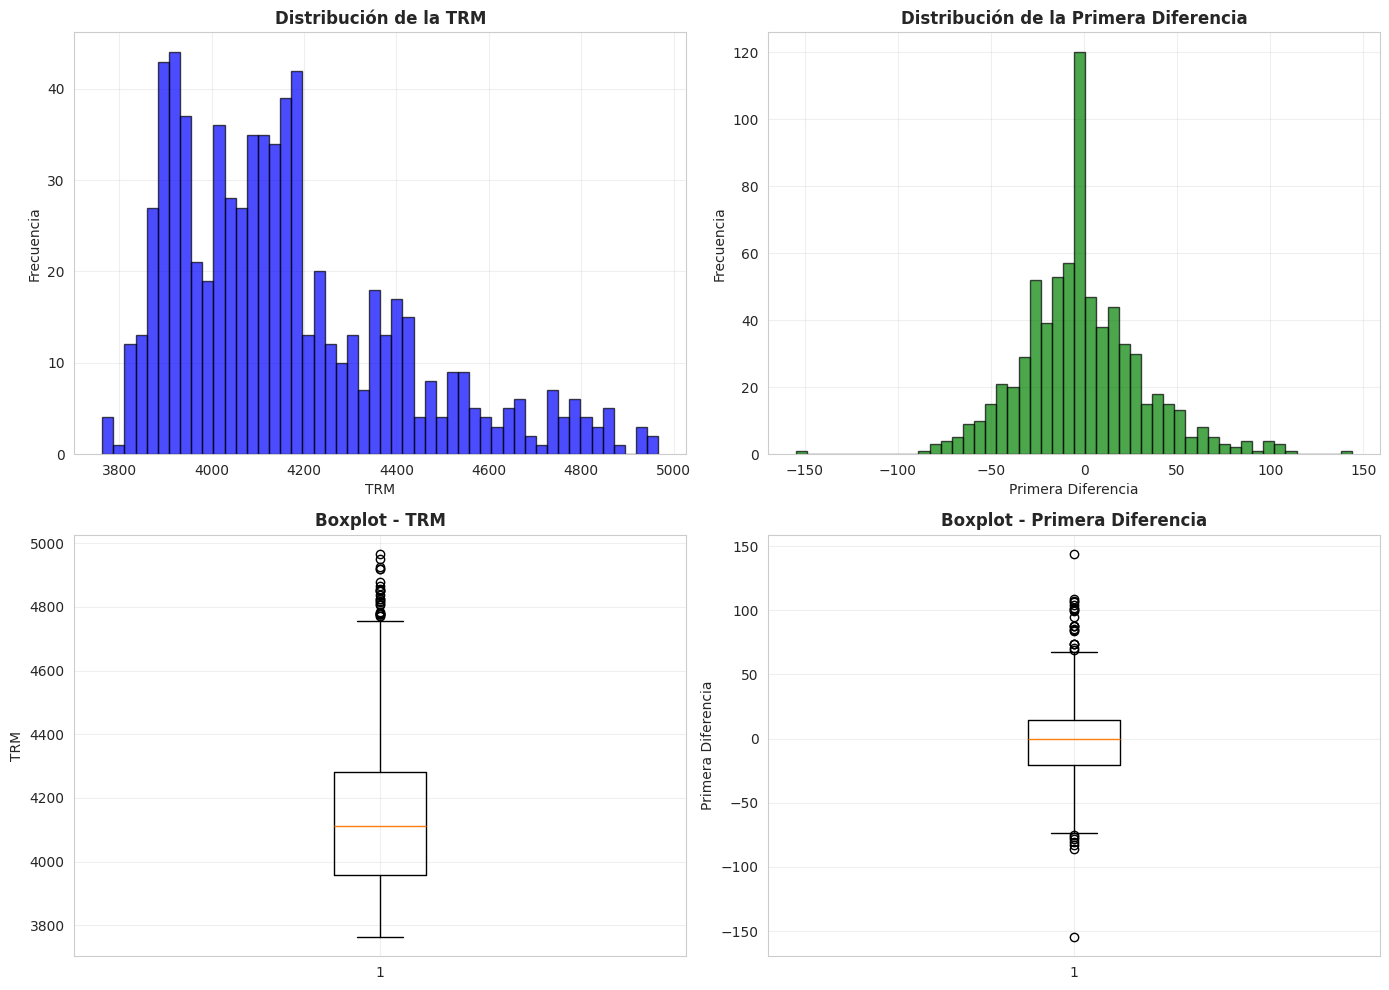

In [19]:
# Histogramas y distribuciones
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Histograma TRM
axes[0, 0].hist(df_preprocessed['trm'].dropna(), bins=50, color='blue', alpha=0.7, edgecolor='black')
axes[0, 0].set_title('Distribución de la TRM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('TRM')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].grid(True, alpha=0.3)

# Histograma primera diferencia
axes[0, 1].hist(df_preprocessed['primera_dif'].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Distribución de la Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Primera Diferencia')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(True, alpha=0.3)

# Boxplot TRM
axes[1, 0].boxplot(df_preprocessed['trm'].dropna(), vert=True)
axes[1, 0].set_title('Boxplot - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('TRM')
axes[1, 0].grid(True, alpha=0.3)

# Boxplot primera diferencia
axes[1, 1].boxplot(df_preprocessed['primera_dif'].dropna(), vert=True)
axes[1, 1].set_title('Boxplot - Primera Diferencia', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Primera Diferencia')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

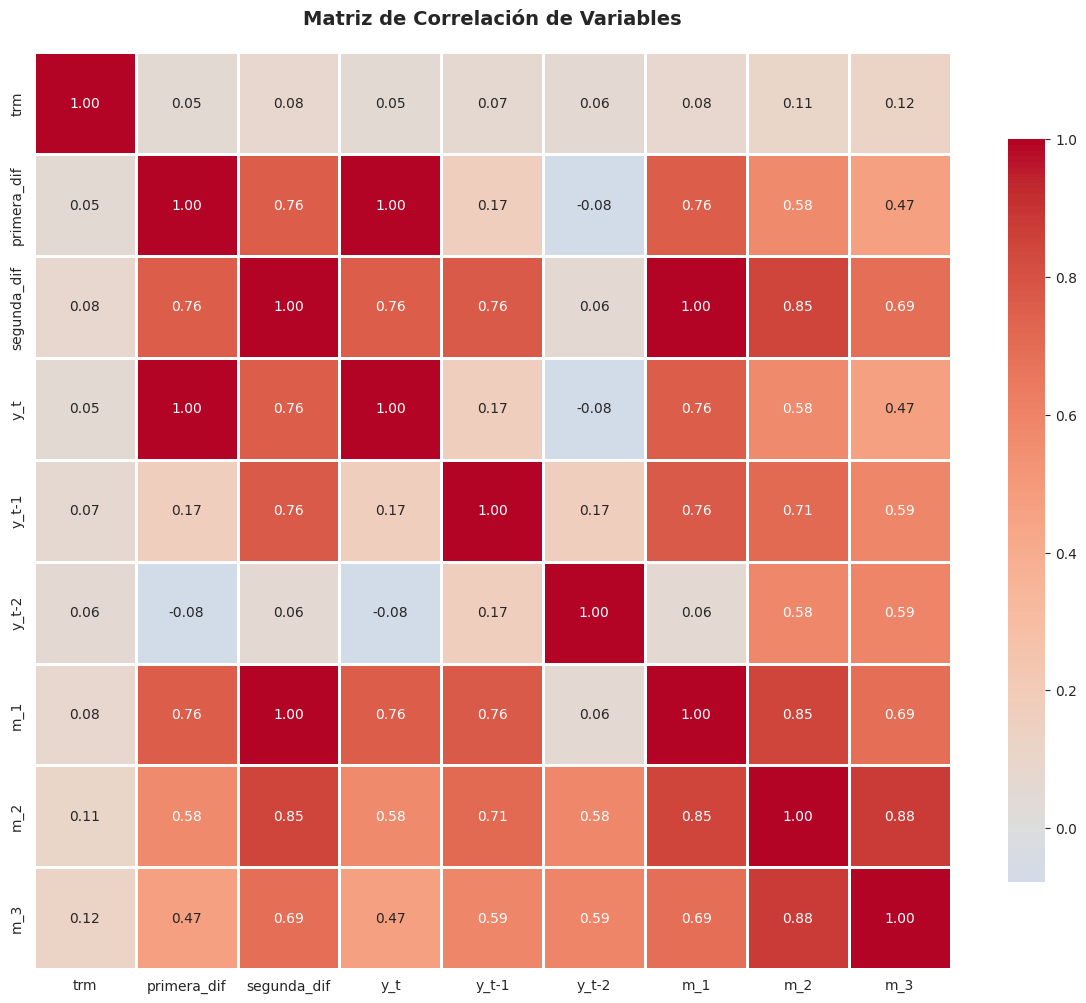

In [20]:
# Matriz de correlación
correlation_cols = ['trm', 'primera_dif', 'segunda_dif', 'y_t', 'y_t-1', 'y_t-2', 'm_1', 'm_2', 'm_3']
corr_matrix = df_preprocessed[correlation_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Matriz de Correlación de Variables', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

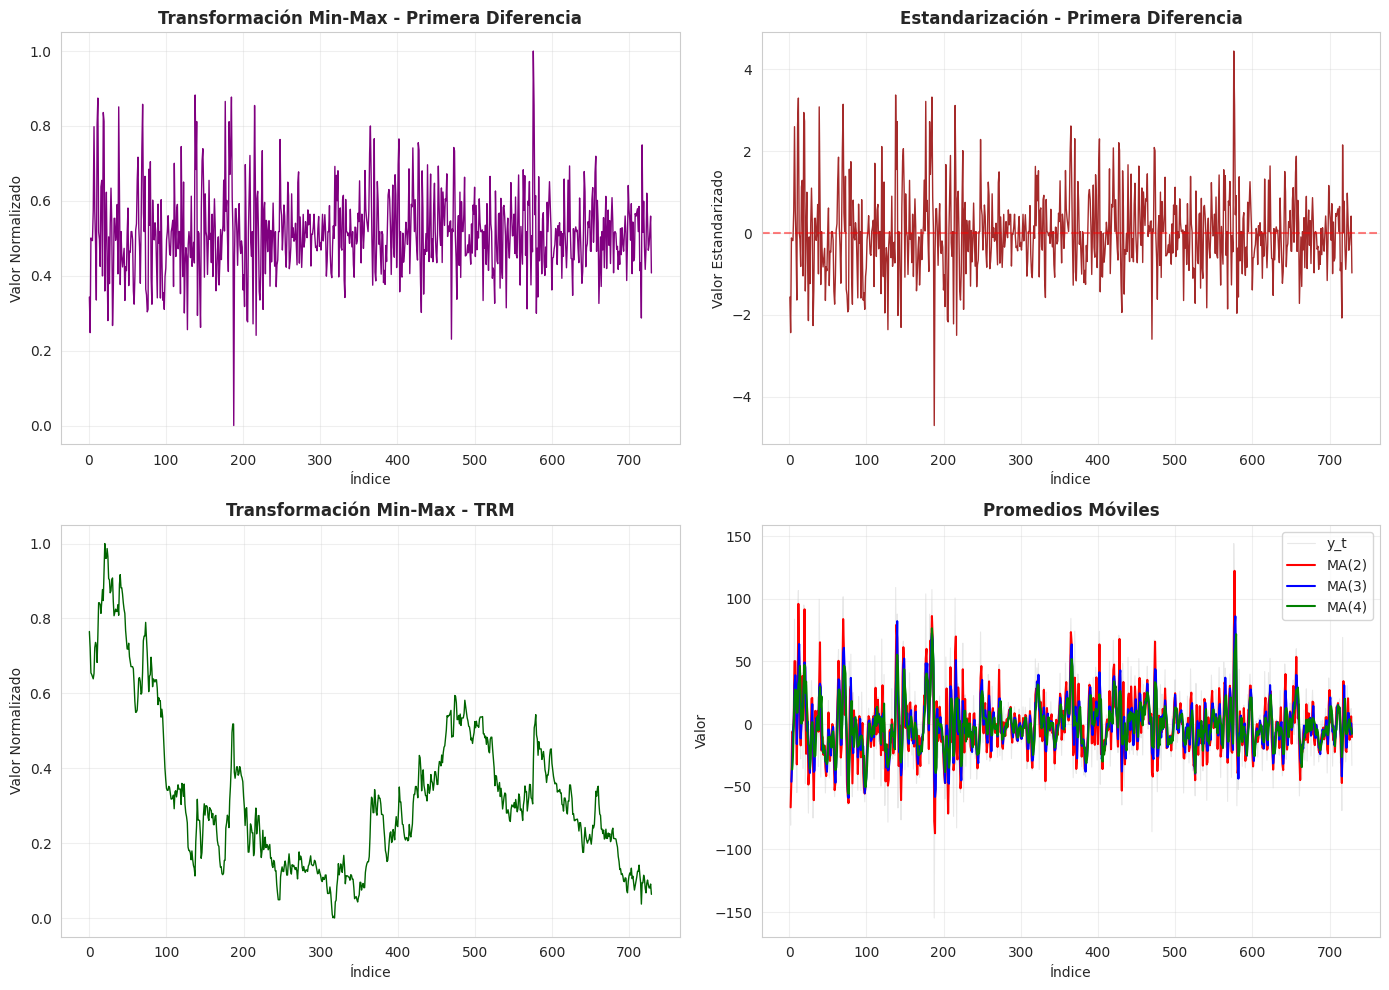

In [21]:
# Análisis de normalización y estandarización
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Transformación min-max de primera diferencia
axes[0, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_primera_dif'], 
                color='purple', linewidth=1)
axes[0, 0].set_title('Transformación Min-Max - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Índice')
axes[0, 0].set_ylabel('Valor Normalizado')
axes[0, 0].grid(True, alpha=0.3)

# Estandarización
axes[0, 1].plot(df_preprocessed.index, df_preprocessed['estandarizacion'], 
                color='brown', linewidth=1)
axes[0, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].set_title('Estandarización - Primera Diferencia', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Índice')
axes[0, 1].set_ylabel('Valor Estandarizado')
axes[0, 1].grid(True, alpha=0.3)

# TRM normalizado
axes[1, 0].plot(df_preprocessed.index, df_preprocessed['trans_max_min_trm'], 
                color='darkgreen', linewidth=1)
axes[1, 0].set_title('Transformación Min-Max - TRM', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Índice')
axes[1, 0].set_ylabel('Valor Normalizado')
axes[1, 0].grid(True, alpha=0.3)

# Promedios móviles
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['y_t'], 
                color='lightgray', linewidth=0.8, alpha=0.5, label='y_t')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_1'], 
                color='red', linewidth=1.5, label='MA(2)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_2'], 
                color='blue', linewidth=1.5, label='MA(3)')
axes[1, 1].plot(df_preprocessed.index, df_preprocessed['m_3'], 
                color='green', linewidth=1.5, label='MA(4)')
axes[1, 1].set_title('Promedios Móviles', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Índice')
axes[1, 1].set_ylabel('Valor')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Resumen estadístico final
print("\n" + "=" * 60)
print("RESUMEN DEL ANÁLISIS EXPLORATORIO")
print("=" * 60)

print("\n1. CARACTERÍSTICAS DEL DATASET:")
print(f"   - Total de observaciones: {len(df_preprocessed)}")
print(f"   - Periodo analizado: {df_preprocessed['periodo'].min()} a {df_preprocessed['periodo'].max()}")
print(f"   - Variables generadas: {len(df_preprocessed.columns)}")

print("\n2. TRM (TASA DE CAMBIO):")
print(f"   - Promedio: {df_preprocessed['trm'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['trm'].median():.2f}")
print(f"   - Mínimo: {df_preprocessed['trm'].min():.2f}")
print(f"   - Máximo: {df_preprocessed['trm'].max():.2f}")
print(f"   - Desviación Estándar: {df_preprocessed['trm'].std():.2f}")

print("\n3. PRIMERA DIFERENCIA:")
print(f"   - Promedio: {df_preprocessed['primera_dif'].mean():.2f}")
print(f"   - Mediana: {df_preprocessed['primera_dif'].median():.2f}")
print(f"   - Rango: [{df_preprocessed['primera_dif'].min():.2f}, {df_preprocessed['primera_dif'].max():.2f}]")
print(f"   - Desviación Estándar: {df_preprocessed['primera_dif'].std():.2f}")

print("\n4. VALORES NULOS:")
print(f"   - Total de valores nulos: {df_preprocessed.isnull().sum().sum()}")
print(f"   - Porcentaje de completitud: {((1 - df_preprocessed.isnull().sum().sum() / (len(df_preprocessed) * len(df_preprocessed.columns))) * 100):.2f}%")

print("\n" + "=" * 60)


RESUMEN DEL ANÁLISIS EXPLORATORIO

1. CARACTERÍSTICAS DEL DATASET:
   - Total de observaciones: 730
   - Periodo analizado: 2023-01-20 00:00:00 a 2025-11-06 00:00:00
   - Variables generadas: 15

2. TRM (TASA DE CAMBIO):
   - Promedio: 4158.01
   - Mediana: 4111.45
   - Mínimo: 3763.43
   - Máximo: 4966.33
   - Desviación Estándar: 248.68

3. PRIMERA DIFERENCIA:
   - Promedio: -1.16
   - Mediana: -0.45
   - Rango: [-154.69, 144.02]
   - Desviación Estándar: 32.62

4. VALORES NULOS:
   - Total de valores nulos: 25
   - Porcentaje de completitud: 99.77%



## Análisis de Residual (Ejercicio hecho en clase)

In [23]:
## Limpieza de nulos
df_preprocessed.dropna(inplace=True)
print(df_clean.isnull().sum())

periodo              0
trm                  0
dia                  0
primera_dif          0
segunda_dif          0
trans_max_min        0
estanrazicacion z    0
trans_max_min.1      0
1dif                 0
y_t                  0
y_t-1                0
y_t-2                0
y_t-3                0
m1                   0
m2                   0
m3                   0
m4                   0
m5                   0
dtype: int64


/tmp/ipykernel_1969/4123291156.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_preprocessed.dropna(inplace=True)


In [24]:
df_preprocessed

,periodo,trm,primera_dif,segunda_dif,trans_max_min_primera_dif,estandarizacion,trans_max_min_trm,primera_dif_trans_max_min_trm,y_t,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,2023-01-26,4538.91,-7.03,-12.11,0.494326,-0.180000,0.644675,-0.005844,-7.03,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
5,2023-01-27,4531.75,-7.16,-14.19,0.493890,-0.183985,0.638723,-0.005952,-7.16,-7.03,-5.08,-80.62,-7.095,-6.423333,-24.9725
6,2023-01-30,4548.50,16.75,9.59,0.573935,0.548985,0.652648,0.013925,16.75,-7.16,-7.03,-5.08,4.795,0.853333,-0.6300
7,2023-01-31,4632.20,83.70,100.45,0.798065,2.601363,0.722230,0.069582,83.70,16.75,-7.16,-7.03,50.225,31.096667,21.5650
8,2023-02-01,4648.70,16.50,100.20,0.573098,0.541321,0.735946,0.013717,16.50,83.70,16.75,-7.16,50.100,38.983333,27.4475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2025-10-31,3870.42,-14.87,-4.42,0.468079,-0.420338,0.088943,-0.012362,-14.87,10.45,30.64,-14.43,-2.210,8.740000,2.9475
726,2025-11-03,3860.12,-10.30,-25.17,0.483379,-0.280243,0.080381,-0.008563,-10.30,-14.87,10.45,30.64,-12.585,-4.906667,3.9800
727,2025-11-04,3860.12,0.00,-10.30,0.517860,0.035507,0.080381,0.000000,0.00,-10.30,-14.87,10.45,-5.150,-8.390000,-3.6800
728,2025-11-05,3872.47,12.35,12.35,0.559205,0.414101,0.090648,0.010267,12.35,0.00,-10.30,-14.87,6.175,0.683333,-3.2050


In [25]:
# Extraccion de columnas de interes para el entrenamiento
y = df_preprocessed['y_t']
X = df_preprocessed[['y_t-1', 'y_t-2', 'y_t-3', 'm_1', 'm_2', 'm_3']]

print(f"Shape of X: {X.shape}")
print(f"Shape of y: {y.shape}")
display(X.head())
display(y.head())

Shape of X: (726, 6)
Shape of y: (726,)


,y_t-1,y_t-2,y_t-3,m_1,m_2,m_3
4,-5.08,-80.62,-52.21,-6.055,-30.910000,-36.2350
5,-7.03,-5.08,-80.62,-7.095,-6.423333,-24.9725
6,-7.16,-7.03,-5.08,4.795,0.853333,-0.6300
7,16.75,-7.16,-7.03,50.225,31.096667,21.5650
8,83.70,16.75,-7.16,50.100,38.983333,27.4475


4    -7.03
5    -7.16
6    16.75
7    83.70
8    16.50
Name: y_t, dtype: float64

In [26]:
from keras.layers import Input

model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

model.summary()

2025-11-20 20:15:09.757607: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,201 (12.50 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 0 (0.00 B)

In [28]:
history = model.fit(X, y, epochs=1000, validation_data=(X, y), verbose=1)
print("Model training complete. History stored.")

Epoch 1/1000
 1/23 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1596 - mean_absolute_error: 0.3164

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3394 - mean_absolute_error: 0.4510 - val_loss: 0.3454 - val_mean_absolute_error: 0.4535
Epoch 2/1000
Epoch 2/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3373 - mean_absolute_error: 0.4461 - val_loss: 0.2820 - val_mean_absolute_error: 0.4125
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3373 - mean_absolute_error: 0.4461 - val_loss: 0.2820 - val_mean_absolute_error: 0.4125
Epoch 3/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3523 - mean_absolute_error: 0.4510 - val_loss: 0.3720 - val_mean_absolute_error: 0.4559
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3523 - mean_absolute_error: 0.4510 - val_loss: 0.3720 - val_mean_absolute_error: 0.4559
Epoch 4/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3004 - mean_absolute_error: 0.4205 - val_loss: 0.2583 - val_mean_absolute_error: 0.4002
Epoch 5/1000
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3004 - mean_absolute_error: 0.4205 - v

In [29]:
y_pred = model.predict(X)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [30]:
eval_results = model.evaluate(X, y, verbose=0)
print(f"Model Evaluation - MSE: {eval_results[0]:.2f}, MAE: {eval_results[1]:.2f}")

residuals = y - y_pred.flatten()
print("Residuals calculated.")

Model Evaluation - MSE: 0.01, MAE: 0.08
Residuals calculated.


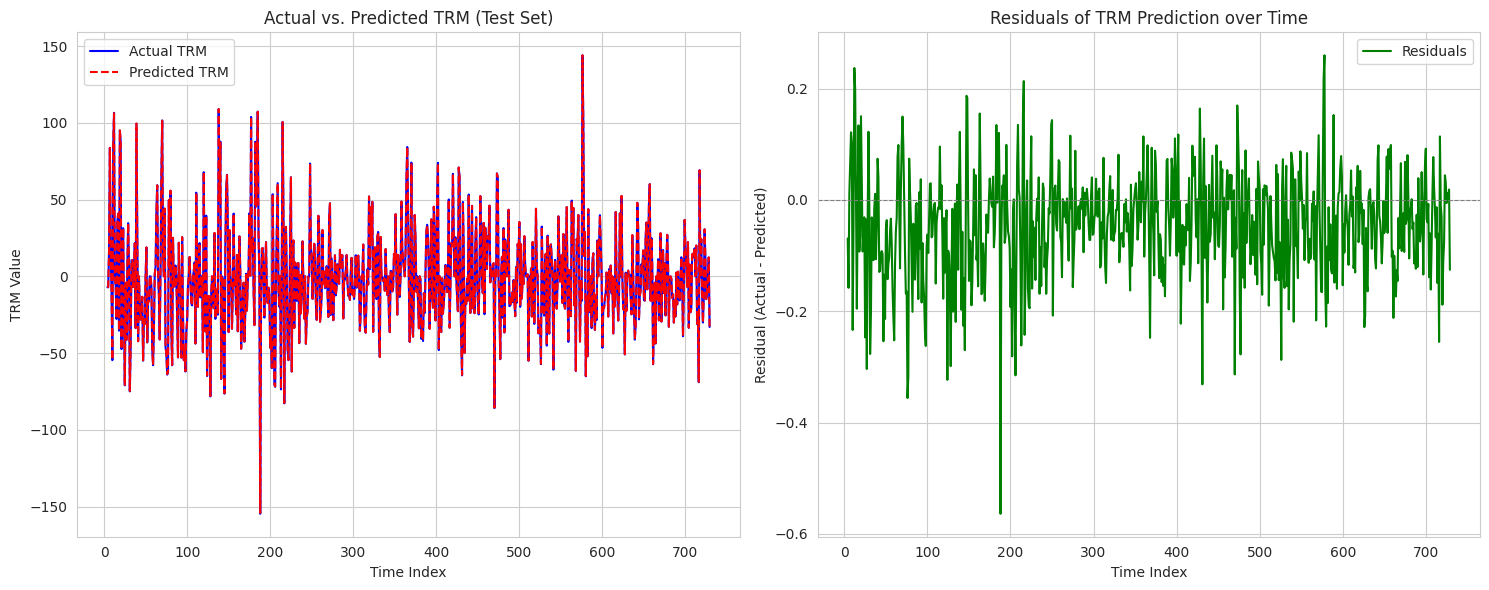

In [32]:
plt.figure(figsize=(15, 6))

# Plot 1: Actual vs. Predicted TRM values
plt.subplot(1, 2, 1) # 1 row, 2 columns, first plot
plt.plot(y.index, y, label='Actual TRM', color='blue')
plt.plot(y.index, y_pred.flatten(), label='Predicted TRM', color='red', linestyle='--')
plt.title('Actual vs. Predicted TRM (Test Set)')
plt.xlabel('Time Index')
plt.ylabel('TRM Value')
plt.legend()
plt.grid(True)

# Plot 2: Residuals over time
plt.subplot(1, 2, 2) # 1 row, 2 columns, second plot
plt.plot(y.index, residuals, label='Residuals', color='green')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Residuals of TRM Prediction over Time')
plt.xlabel('Time Index')
plt.ylabel('Residual (Actual - Predicted)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Queda Analizar las propiedades de los residuales con lo visto en clase